In [8]:
import pickle, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from cv_paper_plots import accuracy, slope

from importlib import reload

In [52]:
colors = ['k', 'gray', 'pink', 'red']
subjects = ['ec2', 'ec9', 'gp31', 'gp33']
chance = [0.0230768918991,
          0.0145569503307,
          0.0193423032761,
          0.0148147940636]
ds_sizes = [2052, 1247, 4173, 1152]

In [53]:
with open(os.path.join(os.environ['HOME'], 'plots/model/data/frac_results.pkl'), 'rb') as f:
    deep_std, deep_all, linear_std, linear_all = pickle.load(f, encoding='latin1')

In [54]:
fracs = sorted(deep_all.keys())

# Accuracy

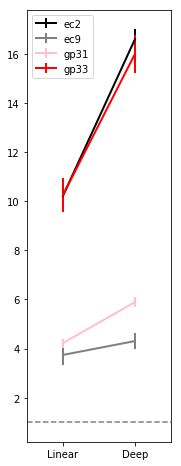

In [55]:
reload(accuracy)
plt.close()
f = plt.figure(figsize=(2, 6))

ax_cv = f.add_axes([0, 0, 1, 1])
accuracy.plot_cv_accuracy(deep_all, linear_all, chance, subjects, fracs[-1], colors, ax_cv)

# Slope

turn frac units into examples units


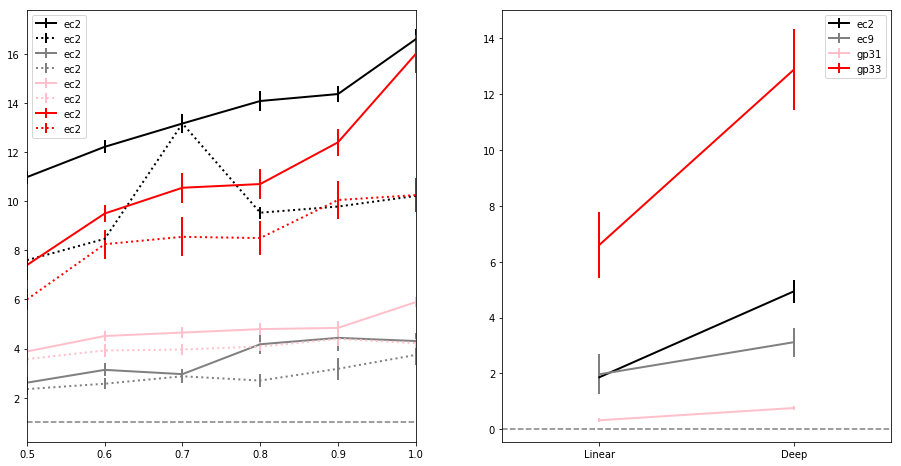

In [61]:
reload(slope)
plt.close()
f = plt.figure(figsize=(12, 6))

ax_ec2 = f.add_axes([0, 0, .45, 1])
ax_slopes = f.add_axes([.55, 0, .45, 1])
slope.plot_cv_slope(deep_all, linear_all, chance, ds_sizes, subjects, fracs, colors, (ax_ec2, ax_slopes))